# Homework 4 Notebook

### 5.2 Warming up

In [124]:
import numpy as np


def run_experiement(n: int) -> tuple[float, float]:
    cos_values = np.random.normal(0.0, 1.0, n)
    print(f"shifted mean: {np.abs(cos_values).mean()}")
    cos_2 = lambda x: np.cos(x) * np.cos(x)
    cos_values = cos_2(cos_values)
    return cos_values.mean(), cos_values.std()

n = 1000000
mean, std = run_experiement(n)
print(F"Mean: {mean}")
print(F"STD: {std}")
print(F"CI: [{mean - 1.96*(std/np.sqrt(n))};{mean + 1.96*(std/np.sqrt(n))}]")

shifted mean: 0.7974630678065935
Mean: 0.5677598826443075
STD: 0.34701476485330585
CI: [0.567079733705195;0.56844003158342]


### 5.3 

In [3]:
x = np.abs(-1)

### 5.4 4

In [5]:
def get_kl_div(samples_f, samples_g):
    log = lambda x: np.log(x)
    samples_f = log(samples_f)
    samples_g = log(samples_g)
    samples_div = samples_f - samples_g
    return samples_div.mean()

n_samples = 100
f_x = np.random.normal(0.0, 1.0, n_samples)
g_x = np.random.normal(1.0, 1.0, n_samples)
div = get_kl_div(f_x, g_x)
print(div)

nan


/tmp/ipykernel_33084/2283010907.py:2: RuntimeWarning: invalid value encountered in log
  log = lambda x: np.log(x)


## 6 Exploration versus Exploitation

In [85]:
from abc import ABC
# Bandit
class OneArmedBandit:
    def __init__(self, mean, 
        std=1.0) -> None:
        self.mean = mean
        self.std = std

    def get_sample(self) -> float:
        return np.random.normal(self.mean, self.std)

# Strategies
class Strategy(ABC):
    def __init__(self) -> None:
        pass

    def get_next_move(self) -> int:
        """Generate the next move of the strategy

        Args:
            previous_moves (list): _description_

        Returns:
            int: the bandit arm to pull on
        """
        raise NotImplementedError
    
    def update_representation(self, bandit: int, return_value: float) -> None:
        """Updates the state of the strategy. This gets the return
        of pulling an arm of a One Armed Bandit.

        Args:
            bandit (int): number of bandit machine
            return_value (float): Return of one armed bandit
        """
        raise NotImplementedError


class EpsilonGreedyStrategy(Strategy):
    def __init__(self, epsilon: float, k: int) -> None:
        """
        Args:
            epsilon (float): probability of non greedy move (explore)
            k (int): number of bandits 
        """
        self.epsilon = epsilon
        self.previous_pulls = [np.empty(shape=(0,)) for i in range(k)]
        self.k = k
    
    def get_next_move(self) -> int:
        greedy = (self.epsilon < np.random.random())
        if greedy:
            filtered = [x.mean() if x.shape[0]!=0 else 0 for x in self.previous_pulls]
            return np.argmax(np.array(filtered))
        return np.random.randint(low=0, high=self.k)

    def update_representation(self, bandit: int, return_value: float) -> None:
        self.previous_pulls[bandit] = np.append(self.previous_pulls[bandit], [return_value])


class UCBStrategy(Strategy):
    def __init__(self, c: float, k: int) -> None:
        self.t = 0
        self.c = c
        self.n = [0] * k
        self.previous_pulls = [np.empty(shape=(0,)) for i in range(k)]
        self.k = 0

    def get_next_move(self) -> int:
        bandit_means = [x.mean() if x.shape[0]!=0 else 0 for x in self.previous_pulls]
        u_t = [self.c * np.sqrt(np.log(self.t)/n) if n!=0 else np.infty for n in self.n]
        upper_bounds = [a + u for a, u in zip(bandit_means, u_t)]
        self.t += 1
        return np.argmax(np.array(upper_bounds))

    def update_representation(self, bandit: int, return_value: float) -> None:
        self.n[bandit] += 1
        self.previous_pulls[bandit] = np.append(self.previous_pulls[bandit], [return_value])


In [111]:


def pull_arms(bandits: list[OneArmedBandit], strategy: Strategy, max_pulls=1000) -> np.ndarray:
    history = np.zeros(shape=(max_pulls,))
    for pull in range(max_pulls):
        bandit_nr = strategy.get_next_move()
        history[pull] = bandits[bandit_nr].mean
        return_value = bandits[bandit_nr].get_sample()
        strategy.update_representation(bandit_nr, return_value)
    return history


def get_expected_regret(q_star: float, history: np.array):
    regret = q_star - history
    return regret


In [99]:

# Get values for e-greedy
k = 2
# epsilon greed< strategy, UCB strategy
egs = EpsilonGreedyStrategy(0.5, k)
bandits = [OneArmedBandit(np.random.random()) for _ in range(k)]
q_star = max([b.mean for b in bandits])
history = pull_arms(bandits, egs)
regret_mean = get_expected_regret(q_star, history)

print(f"q*: {q_star}")
print(f"mean regret: {regret_mean}")

q*: 0.9287129317062807
mean regret: 0.07137017208732144


a1=0.441725831085109, delta a1=0.0
a2=0.3495025420168505, delta a2=0.0922232890682585
q*: 0.441725831085109
mean regret: 0.029419229212774456


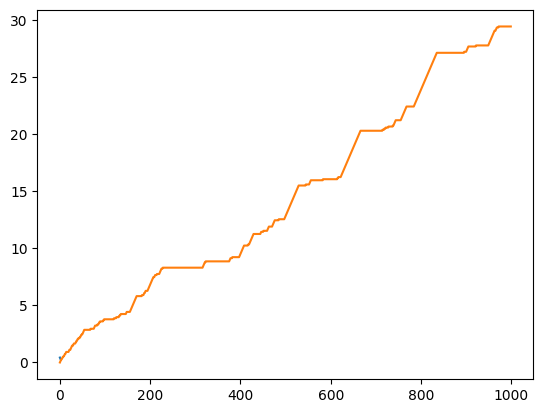

In [179]:
import matplotlib.pyplot as plt
# Get values for UCB
k = 2
# epsilon greed< strategy, UCB strategy
strategy = UCBStrategy(2, k)
bandits = [OneArmedBandit(np.random.random()) for _ in range(k)]
q_star = max([b.mean for b in bandits])
history = pull_arms(bandits, strategy)
regret = get_expected_regret(q_star, history)


plt.plot(list(range(k)), [x.mean() for x in strategy.previous_pulls])
plt.plot(list(range(k)), [b.mean for b in bandits])
#plt.show()
#plt.plot(list(range(len(history))), regret.cumsum())
print(f"a1={bandits[0].mean}, delta a1={q_star-bandits[0].mean}")
print(f"a2={bandits[1].mean}, delta a2={q_star-bandits[1].mean}")
print(f"q*: {q_star}")
print(f"mean regret: {regret.mean()}")